# Chatbot
In this notebook, let's explore how to leverage Google GenAI to consume from a knowledge graph in Neo4j.

This notebook queries an SEC investment graph database using Google Vertex AI Generative AI's `code-bison` model.   We will prompt this model  to convert questions in English to Cypher - Neo4j's query language, which can be used for data retrieval.  It uses the LangChain library in Python to combine the steps for generating queries, executing the queries, and folding the query result sets into a natural language response into one smooth sequence.

## Setup

First, we will install the Python dependencies for this exercise:

In [ ]:
!pip install --upgrade graphdatascience  # Neo4j's GDS client library
!pip install langchain  # library for combining functional steps around LLM calls
!pip install google-cloud-aiplatform  # library for accessing VertexAI
!pip install --upgrade neo4j  # official Neo4j python library

### Neo4j setup

Import your Neo4j libraries.

In [ ]:
from graphdatascience import GraphDataScience
import neo4j

Provide your Neo4j credentials.  We need the DB conection URL, the username (probably `neo4j`), and your password.

In [ ]:
#database credentials
NEO4J_URI="neo4j+s://xxxxx.databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="your_password_here"

Initialize your GDS client connection as below.  We can run queries or algorithms from the `gds` object.

In [ ]:
gds = GraphDataScience(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

### LangChain setup

We will import the relevant submodules from `langchain`.  We are bringing in a Neo4j Question/Answer component, and component for connecting LangChain to the Neo4j graph to be queried, the VertexAI LLM object, and a utility for creating prompt templates that will aid in Cypher query generation.

In [ ]:
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph
from langchain.llms import VertexAI
from langchain.prompts.prompt import PromptTemplate

## Cypher Generation

We have to use a prompt template that clearly states what schema to use, the principles that the chatbot should follow in generating responses, and some few-shot examples to help the chatbot be more accurate in its query generation.

In [ ]:
#prompt/template 
CYPHER_GENERATION_TEMPLATE = """You are an expert Neo4j Cypher translator who understands the question in english and convert to Cypher strictly based on the Neo4j Schema provided and following the instructions below:
1. Generate Cypher query compatible ONLY for Neo4j Version 5
2. Do not use EXISTS, SIZE keywords in the cypher. Use alias when using the WITH keyword
3. Please do not use same variable names for different nodes and relationships in the query.
4. Use only Nodes and relationships mentioned in the schema
5. Always enclose the Cypher output inside 3 backticks
6. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Company name use `toLower(c.name) contains 'neo4j'`
7. Candidate node is synonymous to Manager
8. Always use aliases to refer the node in the query
9. 'Answer' is NOT a Cypher keyword. Answer should never be used in a query.
10. Please generate only one Cypher query per question. 
11. Cypher is NOT SQL. So, do not mix and match the syntaxes.
12. Every Cypher query always starts with a MATCH keyword.

Schema:
{schema}
Samples:
Question: Which fund manager owns most shares? What is the total portfolio value?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) RETURN m.managerName as manager, sum(distinct o.shares) as ownedShares, sum(o.value) as portfolioValue ORDER BY ownedShares DESC LIMIT 10

Question: Which fund manager owns most companies? How many shares?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) RETURN m.managerName as manager, count(distinct c) as ownedCompanies, sum(distinct o.shares) as ownedShares ORDER BY ownedCompanies DESC LIMIT 10

Question: What are the top 10 investments for Vanguard?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) contains "vanguard" RETURN c.companyName as Investment, sum(DISTINCT o.shares) as totalShares, sum(DISTINCT o.value) as investmentValue order by investmentValue desc limit 10

Question: What other fund managers are investing in same companies as Vanguard?
Answer: MATCH (m1:Manager) -[:OWNS]-> (c1:Company) <-[o:OWNS]- (m2:Manager) WHERE toLower(m1.managerName) contains "vanguard" AND elementId(m1) <> elementId(m2) RETURN m2.managerName as manager, sum(DISTINCT o.shares) as investedShares, sum(DISTINCT o.value) as investmentValue ORDER BY investmentValue LIMIT 10

Question: What are the top investors for Apple?
Answer: MATCH (m1:Manager) -[o:OWNS]-> (c1:Company) WHERE toLower(c1.companyName) contains "apple" RETURN distinct m1.managerName as manager, sum(o.value) as totalInvested ORDER BY totalInvested DESC LIMIT 10

Question: What are the other top investments for fund managers investing in Apple?
Answer: MATCH (c1:Company) <-[:OWNS]- (m1:Manager) -[o:OWNS]-> (c2:Company) WHERE toLower(c1.companyName) contains "apple" AND elementId(c1) <> elementId(c2) RETURN DISTINCT c2.companyName as company, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: What are the top investors in the last 3 months?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE date() > o.reportCalendarOrQuarter > o.reportCalendarOrQuarter - duration({{months:3}}) RETURN distinct m.managerName as manager, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: What are top investments in last 6 months for Vanguard?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) contains "vanguard" AND date() > o.reportCalendarOrQuarter > date() - duration({{months:6}}) RETURN distinct c.companyName as company, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: Who are Apple's top investors in last 3 months?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(c.companyName) contains "apple" AND date() > o.reportCalendarOrQuarter > date() - duration({{months:3}}) RETURN distinct m.managerName as investor, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: Which fund manager under 200 million has similar investment strategy as Vanguard?
Answer: MATCH (m1:Manager) -[o1:OWNS]-> (:Company) <-[o2:OWNS]- (m2:Manager) WHERE toLower(m1.managerName) CONTAINS "vanguard" AND elementId(m1) <> elementId(m2) WITH distinct m2 AS m2, sum(distinct o2.value) AS totalVal WHERE totalVal < 200000000 RETURN m2.managerName AS manager, totalVal*0.000001 AS totalVal ORDER BY totalVal DESC LIMIT 10

Question: Who are common investors in Apple and Amazon?
Answer: MATCH (c1:Company) <-[:OWNS]- (m:Manager) -[:OWNS]-> (c2:Company) WHERE toLower(c1.companyName) contains "apple" AND toLower(c2.companyName) CONTAINS "amazon" RETURN DISTINCT m.managerName LIMIT 50

Question: What are Vanguard's top investments by shares for 2023?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) CONTAINS "vanguard" AND date({{year:2023}}) = date.truncate('year',o.reportCalendarOrQuarter) RETURN c.companyName AS investment, sum(o.value) AS totalValue ORDER BY totalValue DESC LIMIT 10

Question: What are Vanguard's top investments by value for 2023?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) CONTAINS "vanguard" AND date({{year:2023}}) = date.truncate('year',o.reportCalendarOrQuarter) RETURN c.companyName AS investment, sum(o.shares) AS totalShares ORDER BY totalShares DESC LIMIT 10

Question: {question}
Answer: 
"""

Create a LangChain prompt template.  This defines the inputs that will be included as parameters into the prompt sent to the Cypher generation bot.  In our example, the inputs will be `schema` and `question`.  The question comes from the end user.  The schema is automatically inserted by the LangChain `GraphCypherQAChain` via a built in method to `Neo4jGraph`.

In [ ]:
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema","question"], validate_template=True, template=CYPHER_GENERATION_TEMPLATE
)

We need to connect to the graph via LangChain.

In [ ]:
#graph object from Langchain
graph = Neo4jGraph(
    url=NEO4J_URI, 
    username=NEO4J_USERNAME, 
    password=NEO4J_PASSWORD
)

We are defining our `chain` object, which combines Neo4j Q/A and VertexAI's `code-bison` LLM.  When the user gives a query, it first goes through `GraphCypherQAChain`, which generates a Cypher query according to the rules laid out in our prompt above.  That result set then goes to the `VertexAI` step of the chain, where the LLM is given the Neo4j result set and instructed to roll it into a natural language response.

In [ ]:
#creating the chain from VertexAI langchain object
chain = GraphCypherQAChain.from_llm(
    VertexAI(model_name='code-bison',
            max_output_tokens=2048,
            temperature=0,
            top_p=0.95,
            top_k=0.40), graph=graph, verbose=True,
            cypher_prompt=CYPHER_GENERATION_PROMPT,
    return_intermediate_steps=True
)

Below we have a few examples of how we can get answers from the chatbot.

In [ ]:
r2 = chain("""What are the top 10 investments for Blackrock?""")
print(f"Final answer: {r2['result']}")

In [ ]:
r3 = chain("""What are other top investments for fund managers investing in AstraZeneca?""")
print(f"Final answer: {r3['result']}")

In [ ]:
r4 = chain("""Which fund manager under 200 million has similar investment strategy as Blackrock""")
print(f"Final answer: {r4['result']}")

In [ ]:
r5 = chain("""Please get me 10 common investors between Tesla and Microsoft""")
print(f"Final answer: {r5['result']}")

In [ ]:
r6 = chain("""Which managers own FAANG stocks?""")
print(f"Final answer: {r6['result']}")

# Chatbot

Now we are going to use Gradio to deploy a chat interface that will have our chain behind it.

## Setup

We will install some libraries:

In [ ]:
!pip install pydantic
!pip install gradio
!pip install IProgress
!pip install tqdm
!pip install typing_extensions

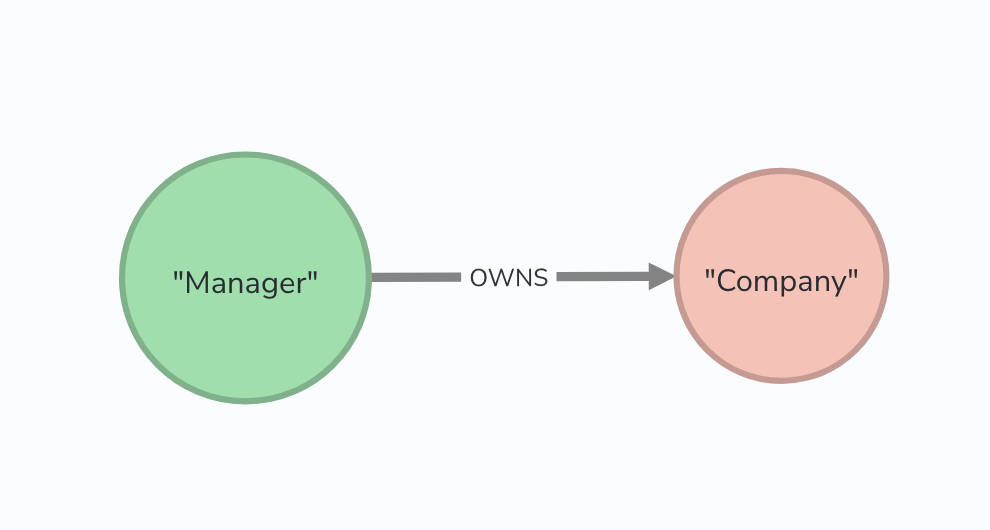

When we run the code below, a Gradio application will be deployed and can be accessed at a local URL.  We also get a public URL that can be shared for 3 days.

In [ ]:
import gradio as gr
import typing_extensions
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key = "chat_history", return_messages = True)
llm = VertexAI(model_name='code-bison',
            max_output_tokens=2048,
            temperature=0,
            top_p=0.95,
            top_k=0.40)
agent_chain = chain

def chat_response(input_text):
    response = agent_chain.run(input_text)
    return response

interface = gr.Interface(fn = chat_response, inputs = "text", outputs = "text", 
                         description = "Investment Chatbot")

interface.launch(share=True)